# Global Optimizers tests

## Scipy

#### Dual Annealing

In [1]:
from scipy.optimize import dual_annealing
import numpy as np

func = lambda x: np.sum(x*x - 10*np.cos(2*np.pi*x)) + 10*np.size(x)
lw = [-5.12] * 10
up = [5.12] * 10

In [2]:
ret = dual_annealing(func, bounds=list(zip(lw, up)), seed=1234)
print("global minimum: xmin = {0}, f(xmin) = {1:.6f}".format(ret.x, ret.fun))

global minimum: xmin = [-4.26437714e-09 -3.91699361e-09 -1.86149218e-09 -3.97165720e-09
 -6.29151648e-09 -6.53145322e-09 -3.93616815e-09 -6.55623025e-09
 -6.05775280e-09 -5.00668935e-09], f(xmin) = 0.000000


#### Simplicial Homology Global Optimization (SHGO)

In [3]:
from scipy.optimize import rosen, shgo
bounds = [(0,2), (0, 2), (0, 2), (0, 2), (0, 2)]

Bounded:

In [4]:
result = shgo(rosen, bounds)
result.x, result.fun

(array([1., 1., 1., 1., 1.]), 2.920392374190081e-18)

Empty bounds:

In [5]:
bounds = [(None, None), ]*4
result = shgo(rosen, bounds)
result.x

array([0.99999851, 0.99999704, 0.99999411, 0.9999882 ])

Egg holder function (many local minima, one global minimum):

In [6]:
def eggholder(x):
    return (-(x[1] + 47.0)
            * np.sin(np.sqrt(abs(x[0]/2.0 + (x[1] + 47.0))))
            - x[0] * np.sin(np.sqrt(abs(x[0] - (x[1] + 47.0))))
            )
bounds = [(-512, 512), (-512, 512)]

In [7]:
result = shgo(eggholder, bounds, n=30, sampling_method='sobol')
result.xl, result.funl

(array([[ 512.        ,  404.23180542],
        [ 283.07593402, -487.12566542],
        [-294.66820039, -462.01964031],
        [-105.87688985,  423.15324143],
        [-242.97923629,  274.38032063],
        [-506.25823477,    6.3131022 ],
        [-408.71980114, -156.10116115],
        [ 150.23210485,  301.31378508],
        [  91.00921872, -391.28375655],
        [ 202.8966344 , -269.38042147],
        [ 361.66625957, -106.96490692],
        [-219.40615102, -244.06022436],
        [ 151.59603137, -100.61082677]]),
 array([-959.64066272, -718.16745962, -704.80659592, -565.99778097,
        -559.78685655, -557.36868733, -507.87385942, -493.9605115 ,
        -426.48799655, -421.15571437, -419.31194957, -410.98477763,
        -202.53912972]))

In [8]:
result_2 = shgo(eggholder, bounds, n=60, iters=5, sampling_method='sobol')
len(result.xl), len(result_2.xl)

(13, 39)

#### Basin Hopping

In [9]:
from scipy.optimize import basinhopping
func = lambda x: np.cos(14.5 * x - 0.3) + (x + 0.2) * x
x0=[1.]

In [10]:
minimizer_kwargs = {"method": "BFGS"}
ret = basinhopping(func, x0, minimizer_kwargs=minimizer_kwargs, niter=200)
print("global minimum: x = %.4f, f(x0) = %.4f" % (ret.x, ret.fun))

global minimum: x = -0.1951, f(x0) = -1.0009


2D minimization problem:

In [11]:
def func2d(x):
    f = np.cos(14.5 * x[0] - 0.3) + (x[1] + 0.2) * x[1] + (x[0] + 0.2) * x[0]
    df = np.zeros(2)
    df[0] = -14.5 * np.sin(14.5 * x[0] - 0.3) + 2. * x[0] + 0.2
    df[1] = 2. * x[1] + 0.2
    return f, df

In [12]:
minimizer_kwargs = {"method":"L-BFGS-B", "jac":True}
x0 = [1.0, 1.0]
ret = basinhopping(func2d, x0, minimizer_kwargs=minimizer_kwargs, niter=200)
print("global minimum: x = [%.4f, %.4f], f(x0) = %.4f" % (ret.x[0],
                                                          ret.x[1],
                                                          ret.fun))

global minimum: x = [-0.1951, -0.1000], f(x0) = -1.0109


Prints output at every step:

In [13]:
def print_fun(x, f, accepted):
        print("at minimum %.4f accepted %d" % (f, int(accepted)))

In [14]:
np.random.seed(1)
ret = basinhopping(func2d, x0, minimizer_kwargs=minimizer_kwargs,
                   niter=10, callback=print_fun)

at minimum 0.4159 accepted 1
at minimum -0.9073 accepted 1
at minimum -0.1021 accepted 1
at minimum -0.1021 accepted 1
at minimum 0.9102 accepted 1
at minimum 0.9102 accepted 1
at minimum 2.2945 accepted 0
at minimum -0.1021 accepted 1
at minimum -1.0109 accepted 1
at minimum -1.0109 accepted 1


Bounded search:

In [15]:
class MyBounds(object):
    def __init__(self, xmax=[1.1,1.1], xmin=[-1.1,-1.1] ):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        return tmax and tmin

In [16]:
mybounds = MyBounds()
ret = basinhopping(func2d, x0, minimizer_kwargs=minimizer_kwargs, niter=10, accept_test=mybounds)

## DEAP - Distributed Evolutionary Algorithms in Python 

In [17]:
def ackley(x):
    """
    Ackley function, 2 dimensional.
    :param x: List of parameters.
    :return: Function result, using the given x parameters.
    """
    arg1 = -0.2 * np.sqrt(0.5 * (x[0] ** 2 + x[1] ** 2))
    arg2 = 0.5 * (np.cos(2. * np.pi * x[0]) + np.cos(2. * np.pi * x[1]))
    return -20. * np.exp(arg1) - np.exp(arg2) + 20. + np.e

In [18]:
import random
from deap import algorithms, base, creator, tools
import numpy as np

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("FitnessMin", base.Fitness, weights=(1.0,))
# creator.create("Individual", list, fitness=creator.FitnessMax)
creator.create("Individual", list, fitness=creator.FitnessMin)

def evalOneMax(individual):
    x = ackley(individual)
    return_value = 1 /  np.sum(x)
    return (return_value,)

# def evalOneMax(individual):
#     return ackley(individual)

toolbox = base.Toolbox()
# toolbox.register("attr_bool", random.randint, 0, 1)
# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=2)
toolbox.register("attr_float", random.random)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

if __name__ == "__main__":
    pop = toolbox.population(n=10)
    
    # One liner black box:
    # algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, verbose=False) # OR
    
    # TODO: find all EA variations -> ~10 GA island versions
    
    # TODO: Gray/white box:    
    ngen, cxpb, mutpb = 20, 0.5, 0.2
    fitnesses = toolbox.map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    for g in range(ngen):
        # TODO: island communication IO
        # TODO: individual attribs should be float in [0, 1]
        # TODO: rescale-encapsulate to NAS Ozone DNN space        
        pop = toolbox.select(pop, k=len(pop))
        
        pop = algorithms.varAnd(pop, toolbox, cxpb, mutpb)
        
        # TODO: Island swap specific individuals        
        print("len(pop)", len(pop))
        print("pop[0]", pop[0])
        if g == 3:
            print("-- Changing in generation 12 an individual")
            pop[0][0] = 0.5
            pop[0][1] = 0.5
            print("-- pop[0]", pop[0])            
            print("-- ", type(pop[0]))
            
        
        invalids = [ind for ind in pop if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalids)
        for ind, fit in zip(invalids, fitnesses):
            ind.fitness.values = fit
    
    print(tools.selBest(pop, k=1))

len(pop) 10
pop[0] [0.396958314454518, 0.3047189835560665]
len(pop) 10
pop[0] [0.07517180684685165, 0.9432776423585174]
len(pop) 10
pop[0] [0.0010241344553834075, 0.12620107917629442]
len(pop) 10
pop[0] [0.0010241344553834075, 0.12620107917629442]
-- Changing in generation 12 an individual
-- pop[0] [0.5, 0.5]
--  <class 'deap.creator.Individual'>
len(pop) 10
pop[0] [0.0010241344553834075, 0.12620107917629442]
len(pop) 10
pop[0] [0.0010241344553834075, 0.12620107917629442]
len(pop) 10
pop[0] [0.0010241344553834075, 0.12620107917629442]
len(pop) 10
pop[0] [0.0, 0.12620107917629442]
len(pop) 10
pop[0] [0.0010241344553834075, 0.12620107917629442]
len(pop) 10
pop[0] [0.0010241344553834075, 0.12620107917629442]
len(pop) 10
pop[0] [0.0, 0.12620107917629442]
len(pop) 10
pop[0] [0.0, 0.12620107917629442]
len(pop) 10
pop[0] [1.0, 0.12620107917629442]
len(pop) 10
pop[0] [0.0, 0.12620107917629442]
len(pop) 10
pop[0] [0.0, 0.12620107917629442]
len(pop) 10
pop[0] [0.0, 0.12620107917629442]
len(pop)

# TPE 

In [19]:
import pickle
import time
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

def objective(x):
    return {
        'loss': x ** 2,
        'status': STATUS_OK,
        # -- store other results like this
        'eval_time': time.time(),
        'other_stuff': {'type': None, 'value': [0, 1, 2]},
        # -- attachments are handled differently
        'attachments':
            {'time_module': pickle.dumps(time.time)}
        }
trials = Trials()
best = fmin(objective,
    space=hp.uniform('x', -10, 10),
    algo=tpe.suggest,
    max_evals=100,
    trials=trials)

print(best)

100%|██████████| 100/100 [00:00<00:00, 565.55it/s, best loss: 0.0062432104300391535]
{'x': -0.0790139888250122}


# Cellular automata

1d to nD index:

In [41]:
CA_dimensions = [3, 6, 2]
max_ranks = 3 * 6 * 2

In [42]:
def get_1D_to_nD(index_1D, max_ranks, CA_dimensions):
    
    returning_nD_index = []   
    n = len(CA_dimensions)
    
    ca = CA_dimensions[0]
    for j in range(1, n):
        ca *= CA_dimensions[j]
        
    for i in range(1, n - 1):
        ca /= CA_dimensions[n - i]
        returning_nD_index.append(int(index_1D / ca))
        index_1D = int(index_1D % ca)
        print("index_1D: {}".format(index_1D))

    returning_nD_index.append(int(index_1D % CA_dimensions[1]))
    returning_nD_index.append(int(index_1D / CA_dimensions[1]))
    returning_nD_index.reverse()   
    return returning_nD_index

In [43]:
def get_nD_to_1D(index_nD, max_ranks, CA_dimensions):
    
    returning_1D_index = 0   
    n = len(CA_dimensions) 
    ca = CA_dimensions[0]
    for i in range(2, n):
        ca *= CA_dimensions[i - 1]
        returning_1D_index += index_nD[-(n - i)] * ca

    returning_1D_index += index_nD[-n] * CA_dimensions[1]
    returning_1D_index += index_nD[-(n - 1)]  
        
    return returning_1D_index

In [270]:
def get_1D_neighbours(index_1D, max_ranks, CA_dimensions):    
    returning_1D_neighbours = []
    index_nD = get_1D_to_nD(index_1D, max_ranks, CA_dimensions)    
    for idx in range(len(CA_dimensions)):
        new_nD = index_nD.copy()
        new_nD[idx] += 1
        if new_nD[idx] >= CA_dimensions[idx]:
            new_nD[idx] = 0
        else:        
            new_1D = get_nD_to_1D(new_nD, max_ranks, CA_dimensions)
            if new_1D >= max_ranks:         
                new_nD[idx] = 0
        new_1D = get_nD_to_1D(new_nD, max_ranks, CA_dimensions)
        returning_1D_neighbours.append(new_1D)
    return returning_1D_neighbours

In [282]:
def get_nD_neighbours(index_1D, max_ranks, CA_dimensions):    
    returning_nD_neighbours = []           
    index_nD = get_1D_to_nD(index_1D, max_ranks, CA_dimensions)    
    for idx in range(len(CA_dimensions)):
        new_nD = index_nD.copy()
        new_nD[idx] += 1
        if new_nD[idx] >= CA_dimensions[idx]:
            new_nD[idx] = 0
        else:        
            new_1D = get_nD_to_1D(new_nD, max_ranks, CA_dimensions)
            if new_1D >= max_ranks:         
                new_nD[idx] = 0        
        returning_nD_neighbours.append(new_nD)           
    return returning_nD_neighbours

In [479]:
def linear_ranking_selection(population_count, selection_pressure, rank_fit):
    s = selection_pressure
    mu = population_count
    i = rank_fit
       
    return (2 - s)/mu + (2 * i * (s - 1))/(mu * (mu - 1))

To be used in rank(0, 1) for picking agent to receive from CA nD neighbours:

In [480]:
mu = 3
rank_fit = 2 # Best: 0, worst: mu -1
s = 1.5 # 1 < s <= 2


for rank_fit in range(2, -1, -1):
    print("p(LR ranked: {}): {}%".format(rank_fit, 100 * linear_ranking_selection(mu, s, rank_fit)))


p(LR ranked: 2): 50.0%
p(LR ranked: 1): 33.33333333333333%
p(LR ranked: 0): 16.666666666666664%


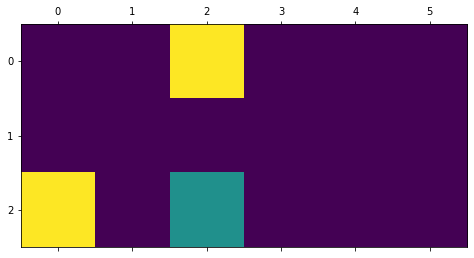

In [291]:
##### import matplotlib.pyplot as plt
import numpy as np

def samplemat(dims, kk, index_nD):
    aa = np.zeros(dims)
    for k in kk:
        aa[k[0], k[1]] = 2
    aa[index_nD[0], index_nD[1]] = 1
    return aa

CA_dimensions = [3, 6]
all_ranks = CA_dimensions[0] * CA_dimensions[1]
max_ranks = all_ranks - 3

index_1D = 14
index_1D = min(index_1D, max_ranks - 1)
mat = samplemat(
    CA_dimensions, get_nD_neighbours(index_1D, max_ranks, CA_dimensions), 
    get_1D_to_nD(index_1D, max_ranks, CA_dimensions))

plt.matshow(mat)

127
index_1D: 50
index_1D: 50


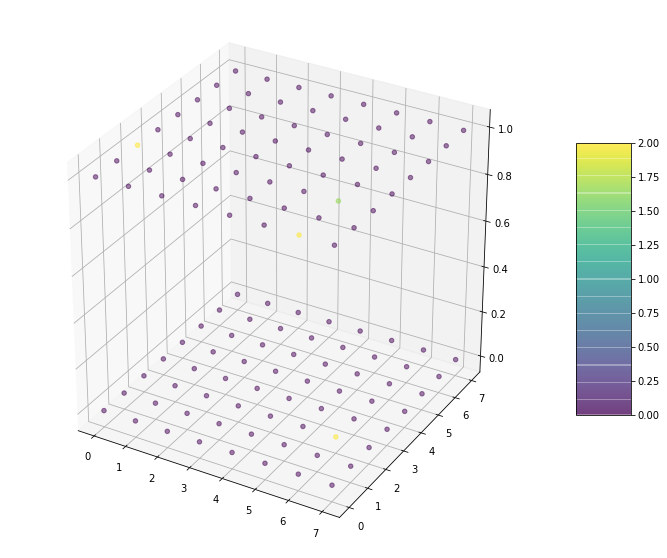

In [441]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def samplemat(dims, kk, index_nD):
    aa = np.zeros(dims)
    for k in kk:
        aa[k[0], k[1], k[2]] = 2
    aa[index_nD[0], index_nD[1], index_nD[2]] = 1.65
    return aa

CA_dimensions = [8, 8, 2]
all_ranks = CA_dimensions[0] * CA_dimensions[1] * CA_dimensions[2]
max_ranks = all_ranks - 13

print((CA_dimensions[0] * CA_dimensions[1] * CA_dimensions[2]) - 1)
index_1D = 114

index_1D = min(index_1D, max_ranks - 1)
mat = samplemat(
    CA_dimensions, get_nD_neighbours(index_1D, max_ranks, CA_dimensions), 
    get_1D_to_nD(index_1D, max_ranks, CA_dimensions))


X, Y, Z = np.mgrid[0:CA_dimensions[0], 0:CA_dimensions[1], 0:CA_dimensions[2]]


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scat = ax.scatter(X, Y, Z, c=mat.flatten(), alpha=0.5)
fig.colorbar(scat, shrink=0.5, aspect=5)

In [368]:
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np

# x, y, z = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 200).transpose()

# trace1 = go.Scatter3d(
#     x=x,
#     y=y,
#     z=z,
#     mode='markers',
#     marker=dict(
#         size=12,
#         line=dict(
#             color='rgba(217, 217, 217, 0.14)',
#             width=0.5
#         ),
#         opacity=0.8
#     )
# )

# x2, y2, z2 = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 200).transpose()
x2, y2, z2 = np.mgrid[0:CA_dimensions[0], 0:CA_dimensions[1], 0:CA_dimensions[2]]
trace2 = go.Scatter3d(
    x=x2,
    y=y2,
    z=z2,
    mode='markers',
    marker=dict(
        color='rgb(127, 127, 127)',
        size=12,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.9
    )
)
data = [trace1, trace2]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

In [361]:
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np

x, y, z = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 200).transpose()
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

x2, y2, z2 = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 200).transpose()
trace2 = go.Scatter3d(
    x=x2,
    y=y2,
    z=z2,
    mode='markers',
    marker=dict(
        color='rgb(127, 127, 127)',
        size=12,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.9
    )
)
data = [trace1, trace2]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

C:\Users\temp3rr0r\Anaconda3\envs\tensorflowLast\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



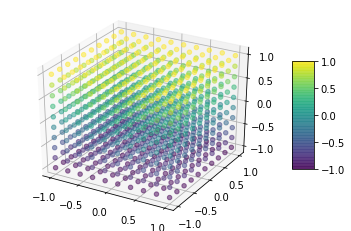

In [294]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

X, Y, Z = np.mgrid[-1:1:10j, -1:1:10j, -1:1:10j]

T = np.exp(-X**2 - Y**2 - Z**2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scat = ax.scatter(X, Y, Z, c=Z.flatten(), alpha=0.5)
fig.colorbar(scat, shrink=0.5, aspect=5)

In [105]:
CA_dimensions = [2, 6]
all_ranks = CA_dimensions[0] * CA_dimensions[1]
max_ranks = all_ranks - 2
print("max_ranks:", max_ranks)
for i in range (0, max_ranks):
    neighbours_1D = get_1D_neighbours(i, max_ranks, CA_dimensions)
    print("{}: {}".format(neighbours_1D, i))

max_ranks: 10
[6, 1]: 0
[7, 2]: 1
[8, 3]: 2
[9, 4]: 3
[4, 5]: 4
[5, 0]: 5
[0, 7]: 6
[1, 8]: 7
[2, 9]: 8
[3, 6]: 9


In [103]:
CA_dimensions = [2, 6]
all_ranks = CA_dimensions[0] * CA_dimensions[1]
max_ranks = all_ranks - 0
for i in range (0, all_ranks):
    neighbours_1D = get_1D_neighbours(i, max_ranks, CA_dimensions)
    print("{}: {}".format(neighbours_1D, i))

[6, 1]: 0
[7, 2]: 1
[8, 3]: 2
[9, 4]: 3
[10, 5]: 4
[11, 0]: 5
[0, 7]: 6
[1, 8]: 7
[2, 9]: 8
[3, 10]: 9
[4, 11]: 10
[5, 6]: 11


In [98]:
CA_dimensions = [2, 6]
all_ranks = CA_dimensions[0] * CA_dimensions[1]
max_ranks = all_ranks - 2
for i in range (0, all_ranks):
    nD_neighbours = get_nD_neighbours(i, max_ranks, CA_dimensions)
    print("{}: {}".format(nD_neighbours, i))

[[1, 0], [0, 1]]: 0
[[1, 1], [0, 2]]: 1
[[1, 2], [0, 3]]: 2
[[1, 3], [0, 4]]: 3
[[0, 4], [0, 5]]: 4
[[0, 5], [0, 0]]: 5
[[0, 0], [1, 1]]: 6
[[0, 1], [1, 2]]: 7
[[0, 2], [1, 3]]: 8
[[0, 3], [1, 0]]: 9
[[0, 4], [1, 0]]: 10
[[0, 5], [1, 0]]: 11


In [95]:
CA_dimensions = [2, 6]
all_ranks = CA_dimensions[0] * CA_dimensions[1]
max_ranks = all_ranks - 0
for i in range (0, all_ranks):
    nD_neighbours = get_nD_neighbours(i, max_ranks, CA_dimensions)
    print("{}: {}".format(nD_neighbours, i))

[[1, 0], [0, 1]]: 0
[[1, 1], [0, 2]]: 1
[[1, 2], [0, 3]]: 2
[[1, 3], [0, 4]]: 3
[[1, 4], [0, 5]]: 4
[[1, 5], [0, 0]]: 5
[[0, 0], [1, 1]]: 6
[[0, 1], [1, 2]]: 7
[[0, 2], [1, 3]]: 8
[[0, 3], [1, 4]]: 9
[[0, 4], [1, 5]]: 10
[[0, 5], [1, 0]]: 11


In [47]:
CA_dimensions = [3, 6]
max_ranks = 3 * 6
for i in range (0, 3 * 6):
    nD = get_1D_to_nD(i, max_ranks, CA_dimensions)
    print("{}: {}({})".format(nD, i,  get_nD_to_1D(nD, max_ranks, CA_dimensions)))

[0, 0]: 0(0)
[0, 1]: 1(1)
[0, 2]: 2(2)
[0, 3]: 3(3)
[0, 4]: 4(4)
[0, 5]: 5(5)
[1, 0]: 6(6)
[1, 1]: 7(7)
[1, 2]: 8(8)
[1, 3]: 9(9)
[1, 4]: 10(10)
[1, 5]: 11(11)
[2, 0]: 12(12)
[2, 1]: 13(13)
[2, 2]: 14(14)
[2, 3]: 15(15)
[2, 4]: 16(16)
[2, 5]: 17(17)


In [22]:
CA_dimensions = [3, 6, 2]
max_ranks = 3 * 6 * 2
for i in range (0, max_ranks):
    nD = get_1D_to_nD(i, max_ranks, CA_dimensions)\
    
    print("{}: {}({})".format(nD, i,  i))
    

index_1D: 0
[0, 0, 0]: 0(0)
index_1D: 1
[0, 1, 0]: 1(1)
index_1D: 2
[0, 2, 0]: 2(2)
index_1D: 3
[0, 3, 0]: 3(3)
index_1D: 4
[0, 4, 0]: 4(4)
index_1D: 5
[0, 5, 0]: 5(5)
index_1D: 6
[1, 0, 0]: 6(6)
index_1D: 7
[1, 1, 0]: 7(7)
index_1D: 8
[1, 2, 0]: 8(8)
index_1D: 9
[1, 3, 0]: 9(9)
index_1D: 10
[1, 4, 0]: 10(10)
index_1D: 11
[1, 5, 0]: 11(11)
index_1D: 12
[2, 0, 0]: 12(12)
index_1D: 13
[2, 1, 0]: 13(13)
index_1D: 14
[2, 2, 0]: 14(14)
index_1D: 15
[2, 3, 0]: 15(15)
index_1D: 16
[2, 4, 0]: 16(16)
index_1D: 17
[2, 5, 0]: 17(17)
index_1D: 0
[0, 0, 1]: 18(18)
index_1D: 1
[0, 1, 1]: 19(19)
index_1D: 2
[0, 2, 1]: 20(20)
index_1D: 3
[0, 3, 1]: 21(21)
index_1D: 4
[0, 4, 1]: 22(22)
index_1D: 5
[0, 5, 1]: 23(23)
index_1D: 6
[1, 0, 1]: 24(24)
index_1D: 7
[1, 1, 1]: 25(25)
index_1D: 8
[1, 2, 1]: 26(26)
index_1D: 9
[1, 3, 1]: 27(27)
index_1D: 10
[1, 4, 1]: 28(28)
index_1D: 11
[1, 5, 1]: 29(29)
index_1D: 12
[2, 0, 1]: 30(30)
index_1D: 13
[2, 1, 1]: 31(31)
index_1D: 14
[2, 2, 1]: 32(32)
index_1D: 15
[2, 

In [25]:
CA_dimensions = [6, 3, 4, 2, 5]
max_ranks = 3 * 4 * 2 * 5 * 6

for i in range (0, 3 * 4 * 2 * 5 * 6):
    nD = get_1D_to_nD(i, max_ranks, CA_dimensions)
    print("{}: {}({})".format(nD, i,  get_nD_to_1D(nD, max_ranks, CA_dimensions)))
#     print("{}: {}({})".format(nD, i, i))

index_1D: 0
index_1D: 0
index_1D: 0
[0, 0, 0, 0, 0]: 0(0)
index_1D: 1
index_1D: 1
index_1D: 1
[0, 1, 0, 0, 0]: 1(1)
index_1D: 2
index_1D: 2
index_1D: 2
[0, 2, 0, 0, 0]: 2(2)
index_1D: 3
index_1D: 3
index_1D: 3
[1, 0, 0, 0, 0]: 3(3)
index_1D: 4
index_1D: 4
index_1D: 4
[1, 1, 0, 0, 0]: 4(4)
index_1D: 5
index_1D: 5
index_1D: 5
[1, 2, 0, 0, 0]: 5(5)
index_1D: 6
index_1D: 6
index_1D: 6
[2, 0, 0, 0, 0]: 6(6)
index_1D: 7
index_1D: 7
index_1D: 7
[2, 1, 0, 0, 0]: 7(7)
index_1D: 8
index_1D: 8
index_1D: 8
[2, 2, 0, 0, 0]: 8(8)
index_1D: 9
index_1D: 9
index_1D: 9
[3, 0, 0, 0, 0]: 9(9)
index_1D: 10
index_1D: 10
index_1D: 10
[3, 1, 0, 0, 0]: 10(10)
index_1D: 11
index_1D: 11
index_1D: 11
[3, 2, 0, 0, 0]: 11(11)
index_1D: 12
index_1D: 12
index_1D: 12
[4, 0, 0, 0, 0]: 12(12)
index_1D: 13
index_1D: 13
index_1D: 13
[4, 1, 0, 0, 0]: 13(13)
index_1D: 14
index_1D: 14
index_1D: 14
[4, 2, 0, 0, 0]: 14(14)
index_1D: 15
index_1D: 15
index_1D: 15
[5, 0, 0, 0, 0]: 15(15)
index_1D: 16
index_1D: 16
index_1D: 16
[5,

index_1D: 4
[1, 1, 3, 1, 0]: 130(130)
index_1D: 131
index_1D: 59
index_1D: 5
[1, 2, 3, 1, 0]: 131(131)
index_1D: 132
index_1D: 60
index_1D: 6
[2, 0, 3, 1, 0]: 132(132)
index_1D: 133
index_1D: 61
index_1D: 7
[2, 1, 3, 1, 0]: 133(133)
index_1D: 134
index_1D: 62
index_1D: 8
[2, 2, 3, 1, 0]: 134(134)
index_1D: 135
index_1D: 63
index_1D: 9
[3, 0, 3, 1, 0]: 135(135)
index_1D: 136
index_1D: 64
index_1D: 10
[3, 1, 3, 1, 0]: 136(136)
index_1D: 137
index_1D: 65
index_1D: 11
[3, 2, 3, 1, 0]: 137(137)
index_1D: 138
index_1D: 66
index_1D: 12
[4, 0, 3, 1, 0]: 138(138)
index_1D: 139
index_1D: 67
index_1D: 13
[4, 1, 3, 1, 0]: 139(139)
index_1D: 140
index_1D: 68
index_1D: 14
[4, 2, 3, 1, 0]: 140(140)
index_1D: 141
index_1D: 69
index_1D: 15
[5, 0, 3, 1, 0]: 141(141)
index_1D: 142
index_1D: 70
index_1D: 16
[5, 1, 3, 1, 0]: 142(142)
index_1D: 143
index_1D: 71
index_1D: 17
[5, 2, 3, 1, 0]: 143(143)
index_1D: 0
index_1D: 0
index_1D: 0
[0, 0, 0, 0, 1]: 144(144)
index_1D: 1
index_1D: 1
index_1D: 1
[0, 1, 0, 0

[1, 2, 2, 1, 1]: 257(257)
index_1D: 114
index_1D: 42
index_1D: 6
[2, 0, 2, 1, 1]: 258(258)
index_1D: 115
index_1D: 43
index_1D: 7
[2, 1, 2, 1, 1]: 259(259)
index_1D: 116
index_1D: 44
index_1D: 8
[2, 2, 2, 1, 1]: 260(260)
index_1D: 117
index_1D: 45
index_1D: 9
[3, 0, 2, 1, 1]: 261(261)
index_1D: 118
index_1D: 46
index_1D: 10
[3, 1, 2, 1, 1]: 262(262)
index_1D: 119
index_1D: 47
index_1D: 11
[3, 2, 2, 1, 1]: 263(263)
index_1D: 120
index_1D: 48
index_1D: 12
[4, 0, 2, 1, 1]: 264(264)
index_1D: 121
index_1D: 49
index_1D: 13
[4, 1, 2, 1, 1]: 265(265)
index_1D: 122
index_1D: 50
index_1D: 14
[4, 2, 2, 1, 1]: 266(266)
index_1D: 123
index_1D: 51
index_1D: 15
[5, 0, 2, 1, 1]: 267(267)
index_1D: 124
index_1D: 52
index_1D: 16
[5, 1, 2, 1, 1]: 268(268)
index_1D: 125
index_1D: 53
index_1D: 17
[5, 2, 2, 1, 1]: 269(269)
index_1D: 126
index_1D: 54
index_1D: 0
[0, 0, 3, 1, 1]: 270(270)
index_1D: 127
index_1D: 55
index_1D: 1
[0, 1, 3, 1, 1]: 271(271)
index_1D: 128
index_1D: 56
index_1D: 2
[0, 2, 3, 1, 1]: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




index_1D: 92
index_1D: 20
index_1D: 2
[0, 2, 1, 1, 3]: 524(524)
index_1D: 93
index_1D: 21
index_1D: 3
[1, 0, 1, 1, 3]: 525(525)
index_1D: 94
index_1D: 22
index_1D: 4
[1, 1, 1, 1, 3]: 526(526)
index_1D: 95
index_1D: 23
index_1D: 5
[1, 2, 1, 1, 3]: 527(527)
index_1D: 96
index_1D: 24
index_1D: 6
[2, 0, 1, 1, 3]: 528(528)
index_1D: 97
index_1D: 25
index_1D: 7
[2, 1, 1, 1, 3]: 529(529)
index_1D: 98
index_1D: 26
index_1D: 8
[2, 2, 1, 1, 3]: 530(530)
index_1D: 99
index_1D: 27
index_1D: 9
[3, 0, 1, 1, 3]: 531(531)
index_1D: 100
index_1D: 28
index_1D: 10
[3, 1, 1, 1, 3]: 532(532)
index_1D: 101
index_1D: 29
index_1D: 11
[3, 2, 1, 1, 3]: 533(533)
index_1D: 102
index_1D: 30
index_1D: 12
[4, 0, 1, 1, 3]: 534(534)
index_1D: 103
index_1D: 31
index_1D: 13
[4, 1, 1, 1, 3]: 535(535)
index_1D: 104
index_1D: 32
index_1D: 14
[4, 2, 1, 1, 3]: 536(536)
index_1D: 105
index_1D: 33
index_1D: 15
[5, 0, 1, 1, 3]: 537(537)
index_1D: 106
index_1D: 34
index_1D: 16
[5, 1, 1, 1, 3]: 538(538)
index_1D: 107
index_1D: 3

[0, 2, 0, 1, 4]: 650(650)
index_1D: 75
index_1D: 3
index_1D: 3
[1, 0, 0, 1, 4]: 651(651)
index_1D: 76
index_1D: 4
index_1D: 4
[1, 1, 0, 1, 4]: 652(652)
index_1D: 77
index_1D: 5

In [26]:
CA_dimensions = [3, 4, 2, 5]
for i in range (0, 3 * 4 * 2 * 5):
    nD = get_1D_to_nD(i, max_ranks, CA_dimensions)
    print("{}: {}({})".format(nD, i,  get_nD_to_1D(nD, max_ranks, CA_dimensions)))
#     print("{}: {}({})".format(nD, i, i))

index_1D: 16
index_1D: 4
[1, 0, 1, 0]: 16(16)
index_1D: 17
index_1D: 5
[1, 1, 1, 0]: 17(17)
index_1D: 18
index_1D: 6
[1, 2, 1, 0]: 18(18)
index_1D: 19
index_1D: 7
[1, 3, 1, 0]: 19(19)
index_1D: 20
index_1D: 8
[2, 0, 1, 0]: 20(20)
index_1D: 21
index_1D: 9
[2, 1, 1, 0]: 21(21)
index_1D: 22
index_1D: 10
[2, 2, 1, 0]: 22(22)
index_1D: 23
index_1D: 11
[2, 3, 1, 0]: 23(23)
index_1D: 0
index_1D: 0
[0, 0, 0, 1]: 24(24)
index_1D: 1
index_1D: 1
[0, 1, 0, 1]: 25(25)
index_1D: 2
index_1D: 2
[0, 2, 0, 1]: 26(26)
index_1D: 3
index_1D: 3
[0, 3, 0, 1]: 27(27)
index_1D: 4
index_1D: 4
[1, 0, 0, 1]: 28(28)
index_1D: 5
index_1D: 5
[1, 1, 0, 1]: 29(29)
index_1D: 6
index_1D: 6
[1, 2, 0, 1]: 30(30)
index_1D: 7
index_1D: 7
[1, 3, 0, 1]: 31(31)
index_1D: 8
index_1D: 8
[2, 0, 0, 1]: 32(32)
index_1D: 9
index_1D: 9
[2, 1, 0, 1]: 33(33)
index_1D: 10
index_1D: 10
[2, 2, 0, 1]: 34(34)
index_1D: 11
index_1D: 11
[2, 3, 0, 1]: 35(35)
index_1D: 12
index_1D: 0
[0, 0, 1, 1]: 36(36)
index_1D: 13
index_1D: 1
[0, 1, 1, 1]: 3

In [27]:
CA_dimensions = [3, 6, 2]
for i in range (0, 3 * 6 * 2):
    nD = get_1D_to_nD(i, max_ranks, CA_dimensions)
    print("{}: {}({})".format(nD, i,  get_nD_to_1D(nD, max_ranks, CA_dimensions)))

index_1D: 0
[0, 0, 0]: 0(0)
index_1D: 1
[0, 1, 0]: 1(1)
index_1D: 2
[0, 2, 0]: 2(2)
index_1D: 3
[0, 3, 0]: 3(3)
index_1D: 4
[0, 4, 0]: 4(4)
index_1D: 5
[0, 5, 0]: 5(5)
index_1D: 6
[1, 0, 0]: 6(6)
index_1D: 7
[1, 1, 0]: 7(7)
index_1D: 8
[1, 2, 0]: 8(8)
index_1D: 9
[1, 3, 0]: 9(9)
index_1D: 10
[1, 4, 0]: 10(10)
index_1D: 11
[1, 5, 0]: 11(11)
index_1D: 12
[2, 0, 0]: 12(12)
index_1D: 13
[2, 1, 0]: 13(13)
index_1D: 14
[2, 2, 0]: 14(14)
index_1D: 15
[2, 3, 0]: 15(15)
index_1D: 16
[2, 4, 0]: 16(16)
index_1D: 17
[2, 5, 0]: 17(17)
index_1D: 0
[0, 0, 1]: 18(18)
index_1D: 1
[0, 1, 1]: 19(19)
index_1D: 2
[0, 2, 1]: 20(20)
index_1D: 3
[0, 3, 1]: 21(21)
index_1D: 4
[0, 4, 1]: 22(22)
index_1D: 5
[0, 5, 1]: 23(23)
index_1D: 6
[1, 0, 1]: 24(24)
index_1D: 7
[1, 1, 1]: 25(25)
index_1D: 8
[1, 2, 1]: 26(26)
index_1D: 9
[1, 3, 1]: 27(27)
index_1D: 10
[1, 4, 1]: 28(28)
index_1D: 11
[1, 5, 1]: 29(29)
index_1D: 12
[2, 0, 1]: 30(30)
index_1D: 13
[2, 1, 1]: 31(31)
index_1D: 14
[2, 2, 1]: 32(32)
index_1D: 15
[2, 

In [28]:
CA_dimensions = [3, 6, 2, 3]
max_ranks = 108

for l in range (0, CA_dimensions[3]):
    for k in range (0, CA_dimensions[2]):
        for i in range(0, CA_dimensions[0]):   
            for j in range(0, CA_dimensions[1]):             
                index_nD = [i, j, k, l]
                print("{}: {}".format(index_nD, get_nD_to_1D(index_nD, max_ranks, CA_dimensions)))

[0, 0, 0, 0]: 0
[0, 1, 0, 0]: 1
[0, 2, 0, 0]: 2
[0, 3, 0, 0]: 3
[0, 4, 0, 0]: 4
[0, 5, 0, 0]: 5
[1, 0, 0, 0]: 6
[1, 1, 0, 0]: 7
[1, 2, 0, 0]: 8
[1, 3, 0, 0]: 9
[1, 4, 0, 0]: 10
[1, 5, 0, 0]: 11
[2, 0, 0, 0]: 12
[2, 1, 0, 0]: 13
[2, 2, 0, 0]: 14
[2, 3, 0, 0]: 15
[2, 4, 0, 0]: 16
[2, 5, 0, 0]: 17
[0, 0, 1, 0]: 18
[0, 1, 1, 0]: 19
[0, 2, 1, 0]: 20
[0, 3, 1, 0]: 21
[0, 4, 1, 0]: 22
[0, 5, 1, 0]: 23
[1, 0, 1, 0]: 24
[1, 1, 1, 0]: 25
[1, 2, 1, 0]: 26
[1, 3, 1, 0]: 27
[1, 4, 1, 0]: 28
[1, 5, 1, 0]: 29
[2, 0, 1, 0]: 30
[2, 1, 1, 0]: 31
[2, 2, 1, 0]: 32
[2, 3, 1, 0]: 33
[2, 4, 1, 0]: 34
[2, 5, 1, 0]: 35
[0, 0, 0, 1]: 36
[0, 1, 0, 1]: 37
[0, 2, 0, 1]: 38
[0, 3, 0, 1]: 39
[0, 4, 0, 1]: 40
[0, 5, 0, 1]: 41
[1, 0, 0, 1]: 42
[1, 1, 0, 1]: 43
[1, 2, 0, 1]: 44
[1, 3, 0, 1]: 45
[1, 4, 0, 1]: 46
[1, 5, 0, 1]: 47
[2, 0, 0, 1]: 48
[2, 1, 0, 1]: 49
[2, 2, 0, 1]: 50
[2, 3, 0, 1]: 51
[2, 4, 0, 1]: 52
[2, 5, 0, 1]: 53
[0, 0, 1, 1]: 54
[0, 1, 1, 1]: 55
[0, 2, 1, 1]: 56
[0, 3, 1, 1]: 57
[0, 4, 1, 1]: 58
[0, 5, 

In [29]:
CA_dimensions = [3, 6, 2]

for k in range (0, CA_dimensions[2]):
    for i in range(0, CA_dimensions[0]):   
        for j in range(0, CA_dimensions[1]):             
            index_nD = [i, j, k]
            print("{}: {}".format(index_nD, get_nD_to_1D(index_nD, max_ranks, CA_dimensions)))

[0, 0, 0]: 0
[0, 1, 0]: 1
[0, 2, 0]: 2
[0, 3, 0]: 3
[0, 4, 0]: 4
[0, 5, 0]: 5
[1, 0, 0]: 6
[1, 1, 0]: 7
[1, 2, 0]: 8
[1, 3, 0]: 9
[1, 4, 0]: 10
[1, 5, 0]: 11
[2, 0, 0]: 12
[2, 1, 0]: 13
[2, 2, 0]: 14
[2, 3, 0]: 15
[2, 4, 0]: 16
[2, 5, 0]: 17
[0, 0, 1]: 18
[0, 1, 1]: 19
[0, 2, 1]: 20
[0, 3, 1]: 21
[0, 4, 1]: 22
[0, 5, 1]: 23
[1, 0, 1]: 24
[1, 1, 1]: 25
[1, 2, 1]: 26
[1, 3, 1]: 27
[1, 4, 1]: 28
[1, 5, 1]: 29
[2, 0, 1]: 30
[2, 1, 1]: 31
[2, 2, 1]: 32
[2, 3, 1]: 33
[2, 4, 1]: 34
[2, 5, 1]: 35


In [30]:
CA_dimensions = [3, 6]
for i in range(0, CA_dimensions[0]):
    for j in range(0, CA_dimensions[1]):
        index_nD = [i, j]
        print("{}: {}".format(index_nD, get_nD_to_1D(index_nD, max_ranks, CA_dimensions)))

[0, 0]: 0
[0, 1]: 1
[0, 2]: 2
[0, 3]: 3
[0, 4]: 4
[0, 5]: 5
[1, 0]: 6
[1, 1]: 7
[1, 2]: 8
[1, 3]: 9
[1, 4]: 10
[1, 5]: 11
[2, 0]: 12
[2, 1]: 13
[2, 2]: 14
[2, 3]: 15
[2, 4]: 16
[2, 5]: 17


In [31]:
CA_dimensions = [3, 2, 2, 3, 2, 3]
max_ranks = 108 * 2

for y in range (0, CA_dimensions[5]):
    for x in range (0, CA_dimensions[4]):
        for l in range (0, CA_dimensions[3]):
            for k in range (0, CA_dimensions[2]):
                for i in range(0, CA_dimensions[0]):   
                    for j in range(0, CA_dimensions[1]):             
                        index_nD = [i, j, k, l, x, y]
                        print("{}: {}".format(index_nD, get_nD_to_1D(index_nD, max_ranks, CA_dimensions)))

[0, 0, 0, 0, 0, 0]: 0
[0, 1, 0, 0, 0, 0]: 1
[1, 0, 0, 0, 0, 0]: 2
[1, 1, 0, 0, 0, 0]: 3
[2, 0, 0, 0, 0, 0]: 4
[2, 1, 0, 0, 0, 0]: 5
[0, 0, 1, 0, 0, 0]: 6
[0, 1, 1, 0, 0, 0]: 7
[1, 0, 1, 0, 0, 0]: 8
[1, 1, 1, 0, 0, 0]: 9
[2, 0, 1, 0, 0, 0]: 10
[2, 1, 1, 0, 0, 0]: 11
[0, 0, 0, 1, 0, 0]: 12
[0, 1, 0, 1, 0, 0]: 13
[1, 0, 0, 1, 0, 0]: 14
[1, 1, 0, 1, 0, 0]: 15
[2, 0, 0, 1, 0, 0]: 16
[2, 1, 0, 1, 0, 0]: 17
[0, 0, 1, 1, 0, 0]: 18
[0, 1, 1, 1, 0, 0]: 19
[1, 0, 1, 1, 0, 0]: 20
[1, 1, 1, 1, 0, 0]: 21
[2, 0, 1, 1, 0, 0]: 22
[2, 1, 1, 1, 0, 0]: 23
[0, 0, 0, 2, 0, 0]: 24
[0, 1, 0, 2, 0, 0]: 25
[1, 0, 0, 2, 0, 0]: 26
[1, 1, 0, 2, 0, 0]: 27
[2, 0, 0, 2, 0, 0]: 28
[2, 1, 0, 2, 0, 0]: 29
[0, 0, 1, 2, 0, 0]: 30
[0, 1, 1, 2, 0, 0]: 31
[1, 0, 1, 2, 0, 0]: 32
[1, 1, 1, 2, 0, 0]: 33
[2, 0, 1, 2, 0, 0]: 34
[2, 1, 1, 2, 0, 0]: 35
[0, 0, 0, 0, 1, 0]: 36
[0, 1, 0, 0, 1, 0]: 37
[1, 0, 0, 0, 1, 0]: 38
[1, 1, 0, 0, 1, 0]: 39
[2, 0, 0, 0, 1, 0]: 40
[2, 1, 0, 0, 1, 0]: 41
[0, 0, 1, 0, 1, 0]: 42
[0, 1, 1, 0, 1, 0]: 4

In [32]:
CA_dimensions = [3, 6, 2, 3, 2]
max_ranks = 108 * 2

for x in range (0, CA_dimensions[4]):
    for l in range (0, CA_dimensions[3]):
        for k in range (0, CA_dimensions[2]):
            for i in range(0, CA_dimensions[0]):   
                for j in range(0, CA_dimensions[1]):             
                    index_nD = [i, j, k, l, x]
                    print("{}: {}".format(index_nD, get_nD_to_1D(index_nD, max_ranks, CA_dimensions)))

[0, 0, 1, 2, 1]: 198
[0, 1, 1, 2, 1]: 199
[0, 2, 1, 2, 1]: 200
[0, 3, 1, 2, 1]: 201
[0, 4, 1, 2, 1]: 202
[0, 5, 1, 2, 1]: 203
[1, 0, 1, 2, 1]: 204
[1, 1, 1, 2, 1]: 205
[1, 2, 1, 2, 1]: 206
[1, 3, 1, 2, 1]: 207
[1, 4, 1, 2, 1]: 208
[1, 5, 1, 2, 1]: 209
[2, 0, 1, 2, 1]: 210
[2, 1, 1, 2, 1]: 211
[2, 2, 1, 2, 1]: 212
[2, 3, 1, 2, 1]: 213
[2, 4, 1, 2, 1]: 214
[2, 5, 1, 2, 1]: 215


In [33]:
CA_dimensions = [3, 6, 2]
max_ranks = 27
index_nD = [1, 3, 1]
returned_1D = get_nD_to_1D(index_nD, max_ranks, CA_dimensions)
print("index_nD: {}, returned_1D: {}".format(index_nD, returned_1D))

CA_dimensions = [3, 6]
max_ranks = 18
index_nD = [2, 2]
returned_1D = get_nD_to_1D(index_nD, max_ranks, CA_dimensions)
print("index_nD: {}, returned_1D: {}".format(index_nD, returned_1D))

CA_dimensions = [3, 6]
max_ranks = 18
index_nD = [1, 2]
returned_1D = get_nD_to_1D(index_nD, max_ranks, CA_dimensions)
print("index_nD: {}, returned_1D: {}".format(index_nD, returned_1D))


index_nD: [1, 3, 1], returned_1D: 27
index_nD: [2, 2], returned_1D: 14
index_nD: [1, 2], returned_1D: 8


In [35]:
CA_dimensions = [3, 6, 2]
max_ranks = 27
index_1D = 27
index_nD = get_1D_to_nD(index_1D, max_ranks, CA_dimensions)

[18, 6]


In [36]:
CA_dimensions = [3, 6, 2, 3]
max_ranks = 108

index_1D = 107
index_nD = get_1D_to_nD(index_1D, max_ranks, CA_dimensions)

[36, 18, 6]
